In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import ConcatDataset, ChainDataset
from torchvision.transforms import RandomHorizontalFlip, Compose
import numpy as np


In [2]:
"""
ResNet paper :
Our implementation for ImageNet follows the practice in [21, 41]. 
The image is resized with its shorter side ran- domly sampled in [256, 480] for scale augmentation [41]. 
A 224×224 crop is randomly sampled from an image or its horizontal flip, with the per-pixel mean subtracted [21]. 
The standard color augmentation in [21] is used

[21] : AlexNet - Dataset section
We did not pre-process the images in any other way, except for subtracting the mean activity over the training set from each pixel. 
So we trained our network on the (centered) raw RGB values of the pixels.

"""

'\nResNet paper :\nOur implementation for ImageNet follows the practice in [21, 41]. \nThe image is resized with its shorter side ran- domly sampled in [256, 480] for scale augmentation [41]. \nA 224×224 crop is randomly sampled from an image or its horizontal flip, with the per-pixel mean subtracted [21]. \nThe standard color augmentation in [21] is used\n\n[21] : AlexNet - Dataset section\nWe did not pre-process the images in any other way, except for subtracting the mean activity over the training set from each pixel. \nSo we trained our network on the (centered) raw RGB values of the pixels.\n\n'

In [3]:
# from typing import Any
# class CustomConcatDataset(ConcatDataset):
#     def __len__(self):
#         # 여기에서 원하는 길이를 반환하도록 사용자 정의
#         # 예시로 첫 번째 데이터셋의 길이 반환
#         return len(self.datasets[0])*2


# class SubtractMean_and_HorizontalFlip():
#     def __init__(self, root, _dataset_name = "CIFAR100"):
#         super().__init__()
#         self.transform_flip = Compose([
#             ToTensor(),
#             RandomHorizontalFlip(p=1.0),
#         ])
        
#         # ger ref data
#         if _dataset_name == "CIFAR100":
#             self.ref_training_data = datasets.CIFAR100(
#                 root = root,
#                 train=True,
#                 download=True,
#                 transform=ToTensor(),
#             )
#             self.ref_test_data = datasets.CIFAR100(
#                 root = root,
#                 train=False,
#                 download=True,
#                 transform=ToTensor(),          
#             )
        
#         # make copy and apply transform(flip)
#         self.training_data1 = self.ref_training_data
#         self.training_data2 = self.ref_training_data
#         self.training_data2.transform = self.transform_flip
        
#         self.test_data1 = self.ref_test_data
#         self.test_data2 = self.ref_test_data
#         self.test_data2.transform = self.transform_flip
        
        
#         # subtract mean
#         mean = self.training_data1.data.mean(axis=(0, 1, 2))
#         self.training_data1.data = self.training_data1.data - mean
#         mean = self.training_data2.data.mean(axis=(0, 1, 2))
#         self.training_data2.data = self.training_data2.data - mean

#         mean = self.test_data1.data.mean(axis=(0, 1, 2))
#         self.test_data1.data = self.test_data1.data - mean
#         mean = self.test_data2.data.mean(axis=(0, 1, 2))
#         self.test_data2.data = self.test_data2.data - mean

#         # merge and 
#         self.training_data = CustomConcatDataset([self.training_data1, self.training_data2])
#         self.test_data = CustomConcatDataset([self.test_data1, self.test_data2])
#         self.training_data.__len__ = lambda: self.training_data1.__len__() + self.training_data2.__len__()
#         self.test_data.__len__ = lambda: self.test_data1.__len__() + self.test_data2.__len__()
#         return None
    
#     def unpack(self, *args: Any, **kwds: Any) -> Any:
#         pass
#         print("SubtractMean_and_HorizontalFlip")
#         return self.training_data, self.test_data
        

### flip까지 완료

In [4]:
# class SubtractMean_and_HorizontalFlip:
#     def __init__(self, root, _dataset_name="CIFAR100"):
#         self.transform_flip = Compose([
#             ToTensor(),
#             RandomHorizontalFlip(p=1.0),
#         ])
        
#         if _dataset_name == "CIFAR100":
#             self.ref_training_data = datasets.CIFAR100(
#                 root=root,
#                 train=True,
#                 download=True,
#                 transform=ToTensor(),
#             )
#             self.ref_test_data = datasets.CIFAR100(
#                 root=root,
#                 train=False,
#                 download=True,
#                 transform=ToTensor(),
#             )

#         # Make copies and apply transforms
#         self.training_data1 = self._apply_transform(self.ref_training_data)
#         self.training_data2 = self._apply_transform(self.ref_training_data, self.transform_flip)

#         self.test_data1 = self._apply_transform(self.ref_test_data)
#         self.test_data2 = self._apply_transform(self.ref_test_data, self.transform_flip)

#         # Merge datasets
#         self.training_data = ConcatDataset([self.training_data1, self.training_data2])
#         self.test_data = ConcatDataset([self.test_data1, self.test_data2])
        
#         # copy classes data
#         self.classes = self.ref_training_data.classes
#         self.training_data.classes = self.classes
#         self.test_data.classes = self.classes
        
#         self.class_to_idx = self.ref_training_data.class_to_idx
#         self.training_data.class_to_idx = self.class_to_idx
#         self.test_data.class_to_idx = self.class_to_idx
        
#     def _apply_transform(self, dataset, transform=None):
#         # when transform is None, return original dataset
#         # when transform is not None, return transformed dataset
#         # -> apply transform_flip
#         transformed_dataset = dataset
#         if transform is not None:
#             transformed_dataset = datasets.CIFAR100(
#                 root=dataset.root,
#                 train=dataset.train,
#                 download=True,  # Set this to False if you've already downloaded the data
#                 transform=transform,
#             )
#         """
#         # Subtract mean
#         하고싶은데, 이거 하면 unit8이 아니라서 dataloader에서 에러남
#         계산결과가 unit8이 아니고, float64로 변환됨.
#         """
#         # Subtract mean
#         # mean = np.mean(transformed_dataset.data, axis=(0, 1, 2))
#         # print(mean)
#         # transformed_dataset.data = transformed_dataset.data - mean
#         # print(np.mean(transformed_dataset.data, axis=(0, 1, 2)))
        
        
#         return transformed_dataset

#     def unpack(self):
#         print("SubtractMean_and_HorizontalFlip")
#         return self.training_data, self.test_data


# """
# subtract mean 적용 안된 것dd1
# """

### submean 시도

In [5]:
from typing import Any


class Submean(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        return None
    """
    def __call__(self, tensor):
    def forward(self, tensor):
    둘 다 가능.
    근데, 처음에 한 번 적용되고 끝이 아니라
    데이터셋에 접근 할 때마다 계속 적용되는 것 같음.
    """
    def __call__(self, tensor):
        # Subtract the mean from each pixel along each channel
        # print("input", tensor.shape)
        _mean = tensor.mean(axis=(1, 2))
        # print("mean value before : ", _mean)
        tensor = tensor - _mean[:, None, None]
        # print("mean value after : ", tensor.mean(axis=(1, 2)))
        
        return tensor
    
    # def forward(self, tensor):
    #     return tensor
    
class SubtractMean_and_HorizontalFlip:
    def __init__(self, root, _dataset_name="CIFAR100"):
        self.transform_flip = Compose([
            ToTensor(),
            RandomHorizontalFlip(p=1.0),
        ])
        self.transform_default = Compose([
            ToTensor(),
            Submean(),
        ])
        if _dataset_name == "CIFAR100":
            self.ref_training_data = datasets.CIFAR100(
                root=root,
                train=True,
                download=True,
                transform=self.transform_default,
            )
            self.ref_test_data = datasets.CIFAR100(
                root=root,
                train=False,
                download=True,
                # transform=self.transform_default,
                transform=ToTensor(),
                
            )
            
        # Make copies
        self.training_data1 = self.ref_training_data
        self.training_data2 = self.ref_training_data
        
        # Apply Flip transform
        self.training_data2.transform = self.transform_flip

        # Merge datasets
        self.training_data = ConcatDataset([self.training_data1, self.training_data2])
        
        # Copy classes data
        self.classes = self.ref_training_data.classes
        self.training_data.classes = self.classes
        
        self.class_to_idx = self.ref_training_data.class_to_idx
        self.training_data.class_to_idx = self.class_to_idx
        
        return 

    def unpack(self):
        print("SubtractMean_and_HorizontalFlip")
        return self.training_data, self.ref_test_data


"""
subtract mean 적용 한 것.

아니 왜 training set에서는 sub mean이 잘 되는데, test set에서는 sub mean하면 안되는거야?

"""

'\nsubtract mean 적용 한 것.\n\n아니 왜 training set에서는 sub mean이 잘 되는데, test set에서는 sub mean하면 안되는거야?\n\n'

In [6]:
# Usage
batch_size = 256
_dataset = SubtractMean_and_HorizontalFlip('data', 'CIFAR100')
training_data, test_data = _dataset.unpack()

Files already downloaded and verified
Files already downloaded and verified
SubtractMean_and_HorizontalFlip


In [7]:
batch_size = 256
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)


In [8]:
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print("mean of X", X.mean(dim=(0, 2, 3)))
    print(f"Shape of y: {y.shape} {y.dtype}")
    break
# print(train_dataloader.dataset[0])
# print(train_dataloader.dataset[1])
print(test_dataloader.dataset.classes)
print("class len : ", len(test_dataloader.dataset.classes))
# print(test_dataloader.dataset.class_to_idx)

Shape of X [N, C, H, W]: torch.Size([256, 3, 32, 32])
mean of X tensor([0.5154, 0.4842, 0.4331])
Shape of y: torch.Size([256]) torch.int64
['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper

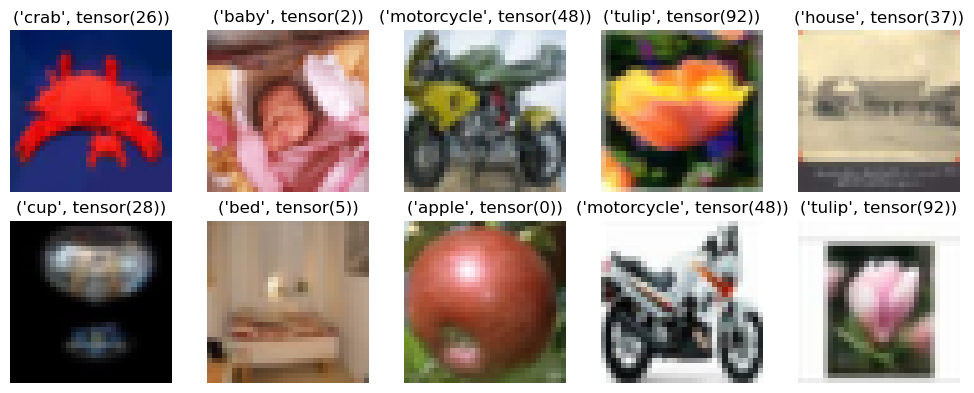

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Get the class names
class_names = test_dataloader.dataset.classes
count = 0

# Create a subplot with 2 rows and 5 columns
fig, axs = plt.subplots(2, 5, figsize=(10, 4))

# Iterate over the first batch of images and labels
for images, labels in test_dataloader:
    # Convert the images to numpy arrays
    images = images.numpy()
    
    # Iterate over the images and labels
    for i in range(len(images)):
        # Get the image and label
        image = images[i]
        label = labels[i]
        
        # Convert the image from tensor to numpy array
        image = np.transpose(image, (1, 2, 0))
        
        # Plot the image in the appropriate subplot
        ax = axs[count // 5, count % 5]
        ax.imshow(image)
        ax.set_title(f"{class_names[label], label}")
        ax.axis('off')
        
        # Increment the count
        count += 1
        
        # Break the loop if we have displayed 10 images
        if count == 10:
            break
            
    # Break the loop if we have displayed 10 images
    if count == 10:
        break

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [10]:
# 학습에 사용할 CPU나 GPU, MPS 장치를 얻습니다.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [11]:
class Block(nn.Module):
    def __init__(self, inputs, outputs, _Downsample = False):
        super().__init__()
        self._Downsample = _Downsample

        
        self.conv1 = nn.Conv2d(inputs, outputs, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(outputs, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu1 = nn.ReLU(inplace=False)
        
        self.conv2 = nn.Conv2d(outputs, outputs, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(outputs, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        #self.relu2 = nn.ReLU(inplace=False)
        
        if self._Downsample == True:
            self.downsampling = nn.Sequential(
                # In paper, 
                # downsampling is performed by conv3_1, conv4_1, and conv5_1 with a stride of 2
                nn.Conv2d(inputs, outputs, kernel_size=1, stride=2, bias=False),
                nn.BatchNorm2d(outputs, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                # 이거 토치 공식 resnet에서도 배치까지 있는 4차원이라 conv2d로 함.
            )
            
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m == self.conv1 and self._Downsample == True:
                    m.stride = (2, 2)
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # print('x1(identity) :', x.shape, 'Downsample :', self._Downsample)
        identity = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        # print('x2 :', x.shape)
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self._Downsample == True:
            identity = self.downsampling(identity)
            # print('x1(downsampled) :', identity.shape)
        x = x + identity # 여기 x+=identity로 하면 안됨. inplace operation이라서.
        
        #x = self.relu2(x)
        # print('x3 :', x.shape)
        # print('x4 :', x.shape)
        return x
    
class MyResNet34(nn.Module):
    def __init__(self, _BlockClass = Block, _num_classes = 1000, _print = False):
        super().__init__()
        self._num_classes = _num_classes
        self._print = _print
        
        # 1. input layer
        # input : 224x224x3
        # output : 112x112x64
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels= 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu1 = nn.ReLU(inplace=False)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        
        # 2. 64ch 3x3 conv x 3
        # input : 112x112x64
        # output : 56x56x64
        self.conv64blocks = nn.Sequential(
            _BlockClass(64, 64),
            _BlockClass(64, 64),
            _BlockClass(64, 64)
        )
        # 3. 128ch 3x3 conv x 4
        # input : 56x56x64
        # output : 28x28x128
        self.conv128blocks = nn.Sequential(
            _BlockClass(64, 128, _Downsample = True),
            _BlockClass(128, 128),
            _BlockClass(128, 128),
            _BlockClass(128, 128)
        )
        # 4. 256ch 3x3 conv x 6
        # input : 28x28x128
        # output : 14x14x256
        self.conv256blocks = nn.Sequential(
            _BlockClass(128, 256, _Downsample = True),
            _BlockClass(256, 256),
            _BlockClass(256, 256),
            _BlockClass(256, 256),
            _BlockClass(256, 256),
            _BlockClass(256, 256)
        )
        # 5. 512ch 3x3 conv x 3
        # input : 14x14x256
        # output : 7x7x512
        self.conv512blocks = nn.Sequential(
            _BlockClass(256, 512, _Downsample = True),
            _BlockClass(512, 512),
            _BlockClass(512, 512)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(in_features = 512, out_features= self._num_classes, bias=True)
        #self.relu2 = nn.ReLU(inplace=False)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
    def forward(self, x):
        if(self._print): print('input 64ch :', x.shape)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        if(self._print): print('conv7x7 64ch :', x.shape)
        x = self.maxpool(x)
        if(self._print): print('maxpool 64ch :', x.shape)
        
        x = self.conv64blocks(x)
        if(self._print): print('1st conv 64 :', x.shape)
        
        x = self.conv128blocks(x)
        if(self._print): print('2nd conv 128 :', x.shape)
        
        x = self.conv256blocks(x)
        if(self._print): print('3rd conv 256 :', x.shape)
        
        x = self.conv512blocks(x)
        if(self._print): print('4th conv 512:', x.shape)
        
        x = self.avgpool(x)
        if(self._print): print('avgpool :', x.shape)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        #x = self.relu2(x)
        if(self._print): print('fc :', x.shape)
        
        return x
        
"""
    - 왜 블럭 하나엔 relu가 하나만 있을까?
    
"""
    

'\n    - 왜 블럭 하나엔 relu가 하나만 있을까?\n    \n'

In [12]:
# for cifar100
model = MyResNet34(Block, 100, _print=False).to(device)
model.named_modules

<bound method Module.named_modules of MyResNet34(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv64blocks): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU

In [13]:
"""
    we initialize the weights as on He initialization
    we adopt batch normalization after each convolutional and before activation
    we use SGD with a mini-batch size of 256
    the learning rate starts from 0.1 and is divided by 10 when the error plateaus
    we use a weight decay of 0.0001 and a momentum of 0.9
    we do not use dropout
    
"""

'\n    we initialize the weights as on He initialization\n    we adopt batch normalization after each convolutional and before activation\n    we use SGD with a mini-batch size of 256\n    the learning rate starts from 0.1 and is divided by 10 when the error plateaus\n    we use a weight decay of 0.0001 and a momentum of 0.9\n    we do not use dropout\n    \n'

In [14]:
# 모델 생성 및 손실 함수, 최적화기 정의
criterion = nn.CrossEntropyLoss()
"""
    It is useful when training a classification problem with C classes. 
    If provided, the optional argument weight should be a 1D Tensor assigning weight to each of the classes. 
    This is particularly useful when you have an unbalanced training set.
    
    The input is expected to contain the unnormalized logits for each class (which do not need to be positive or sum to 1, in general).
"""
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=0.0001, momentum=0.9)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

In [15]:

# Training loop
num_epochs = 20

_log_train_loss = []
_log_train_acc = []
_log_test_loss = []
_log_test_acc = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    #for inputs, labels in tqdm.tqdm(train_dataloader):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_dataloader)
    train_acc = correct / total

    # Evaluation loop
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss /= len(test_dataloader)
    test_acc = correct / total

    # Print epoch statistics
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")
    print("-" * 50)
    _log_train_loss.append(train_loss)
    _log_train_acc.append(train_acc)
    _log_test_loss.append(test_loss)
    _log_test_acc.append(test_acc)


Epoch 1/20:
Train Loss: 3.1422 | Train Acc: 24.66%
Test Loss: 3.2188 | Test Acc: 25.13%
--------------------------------------------------
Epoch 2/20:
Train Loss: 2.1513 | Train Acc: 43.65%
Test Loss: 2.7954 | Test Acc: 32.26%
--------------------------------------------------
Epoch 3/20:
Train Loss: 1.5005 | Train Acc: 58.55%
Test Loss: 3.5979 | Test Acc: 26.89%
--------------------------------------------------
Epoch 4/20:
Train Loss: 0.9560 | Train Acc: 72.10%
Test Loss: 3.2056 | Test Acc: 34.93%
--------------------------------------------------
Epoch 5/20:
Train Loss: 0.5805 | Train Acc: 82.14%
Test Loss: 3.6101 | Test Acc: 34.99%
--------------------------------------------------
Epoch 6/20:
Train Loss: 0.3323 | Train Acc: 89.58%
Test Loss: 3.9265 | Test Acc: 35.32%
--------------------------------------------------
Epoch 7/20:
Train Loss: 0.2261 | Train Acc: 92.85%
Test Loss: 4.2077 | Test Acc: 36.39%
--------------------------------------------------
Epoch 8/20:
Train Loss: 0.1

In [16]:
"""
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

Epoch 1/20:
Train Loss: 3.0912 | Train Acc: 25.55%
Test Loss: 2.8584 | Test Acc: 29.58%
--------------------------------------------------
Epoch 2/20:
Train Loss: 2.1072 | Train Acc: 44.44%
Test Loss: 2.7571 | Test Acc: 34.34%
--------------------------------------------------
Epoch 3/20:
Train Loss: 1.4850 | Train Acc: 58.83%
Test Loss: 3.2414 | Test Acc: 31.20%
--------------------------------------------------
Epoch 4/20:
Train Loss: 0.9535 | Train Acc: 72.06%
Test Loss: 3.2823 | Test Acc: 35.43%
--------------------------------------------------
Epoch 5/20:
Train Loss: 0.5815 | Train Acc: 82.14%
Test Loss: 3.5647 | Test Acc: 35.08%
--------------------------------------------------
Epoch 6/20:
Train Loss: 0.3484 | Train Acc: 89.02%
Test Loss: 3.8185 | Test Acc: 36.23%
--------------------------------------------------
Epoch 7/20:
Train Loss: 0.2282 | Train Acc: 92.73%
Test Loss: 4.3447 | Test Acc: 35.07%
--------------------------------------------------
Epoch 8/20:
Train Loss: 0.1531 | Train Acc: 95.08%
Test Loss: 4.4567 | Test Acc: 36.24%
--------------------------------------------------
Epoch 9/20:
Train Loss: 0.1027 | Train Acc: 96.84%
Test Loss: 4.4752 | Test Acc: 37.26%
--------------------------------------------------
Epoch 10/20:
Train Loss: 0.0572 | Train Acc: 98.33%
Test Loss: 4.6574 | Test Acc: 36.88%
--------------------------------------------------
Epoch 11/20:
Train Loss: 0.0340 | Train Acc: 99.09%
Test Loss: 4.6533 | Test Acc: 38.97%
--------------------------------------------------
Epoch 12/20:
Train Loss: 0.0122 | Train Acc: 99.78%
Test Loss: 4.5087 | Test Acc: 39.71%
--------------------------------------------------
Epoch 13/20:
Train Loss: 0.0056 | Train Acc: 99.93%
Test Loss: 4.3820 | Test Acc: 41.15%
--------------------------------------------------
Epoch 14/20:
Train Loss: 0.0032 | Train Acc: 99.95%
Test Loss: 4.3798 | Test Acc: 41.30%
--------------------------------------------------
Epoch 15/20:
Train Loss: 0.0029 | Train Acc: 99.95%
Test Loss: 4.3010 | Test Acc: 41.36%
--------------------------------------------------
Epoch 16/20:
Train Loss: 0.0025 | Train Acc: 99.95%
Test Loss: 4.2975 | Test Acc: 41.70%
--------------------------------------------------
Epoch 17/20:
Train Loss: 0.0018 | Train Acc: 99.96%
Test Loss: 4.2540 | Test Acc: 41.34%
--------------------------------------------------
Epoch 18/20:
Train Loss: 0.0019 | Train Acc: 99.96%
Test Loss: 4.2364 | Test Acc: 41.62%
--------------------------------------------------
Epoch 19/20:
Train Loss: 0.0018 | Train Acc: 99.96%
Test Loss: 4.2482 | Test Acc: 41.57%
--------------------------------------------------
Epoch 20/20:
Train Loss: 0.0016 | Train Acc: 99.96%
Test Loss: 4.2381 | Test Acc: 41.72%
--------------------------------------------------
"""
"""
adam

Epoch 1/20:
Train Loss: 4.3754 | Train Acc: 5.81%
Test Loss: 3.8439 | Test Acc: 9.40%
--------------------------------------------------
Epoch 2/20:
Train Loss: 3.4959 | Train Acc: 16.02%
Test Loss: 3.3953 | Test Acc: 19.77%
--------------------------------------------------
Epoch 3/20:
Train Loss: 3.0369 | Train Acc: 24.35%
Test Loss: 3.2483 | Test Acc: 22.07%
--------------------------------------------------
Epoch 4/20:
Train Loss: 2.7440 | Train Acc: 30.33%
Test Loss: 3.1309 | Test Acc: 24.46%
--------------------------------------------------
Epoch 5/20:
Train Loss: 2.5640 | Train Acc: 33.88%
Test Loss: 2.7762 | Test Acc: 29.13%
--------------------------------------------------
Epoch 6/20:
Train Loss: 2.4598 | Train Acc: 36.21%
Test Loss: 2.6288 | Test Acc: 33.05%
--------------------------------------------------
Epoch 7/20:
Train Loss: 2.3683 | Train Acc: 38.40%
Test Loss: 2.6096 | Test Acc: 33.15%
--------------------------------------------------
Epoch 8/20:
Train Loss: 2.2050 | Train Acc: 41.57%
Test Loss: 2.7508 | Test Acc: 31.27%
--------------------------------------------------
Epoch 9/20:
Train Loss: 2.1077 | Train Acc: 43.59%
Test Loss: 2.4139 | Test Acc: 38.08%
--------------------------------------------------
Epoch 10/20:
Train Loss: 2.0083 | Train Acc: 45.74%
Test Loss: 5.6742 | Test Acc: 17.36%
--------------------------------------------------
Epoch 11/20:
Train Loss: 1.9328 | Train Acc: 47.53%
Test Loss: 2.4851 | Test Acc: 36.23%
--------------------------------------------------
Epoch 12/20:
Train Loss: 1.8399 | Train Acc: 49.68%
Test Loss: 2.5965 | Test Acc: 35.21%
--------------------------------------------------
Epoch 13/20:
Train Loss: 1.8101 | Train Acc: 50.11%
Test Loss: 2.5114 | Test Acc: 37.40%
--------------------------------------------------
Epoch 14/20:
Train Loss: 1.7256 | Train Acc: 52.24%
Test Loss: 2.6367 | Test Acc: 37.48%
--------------------------------------------------
Epoch 15/20:
Train Loss: 1.6665 | Train Acc: 53.33%
Test Loss: 2.5881 | Test Acc: 37.91%
--------------------------------------------------
Epoch 16/20:
Train Loss: 1.5989 | Train Acc: 54.97%
Test Loss: 2.6587 | Test Acc: 37.56%
--------------------------------------------------
Epoch 17/20:
Train Loss: 1.5630 | Train Acc: 55.81%
Test Loss: 2.6409 | Test Acc: 37.35%
--------------------------------------------------
Epoch 18/20:
Train Loss: 1.5145 | Train Acc: 56.95%
Test Loss: 2.8257 | Test Acc: 36.17%
--------------------------------------------------
Epoch 19/20:
Train Loss: 1.4884 | Train Acc: 57.61%
Test Loss: 2.9181 | Test Acc: 33.34%
--------------------------------------------------
Epoch 20/20:
Train Loss: 1.4475 | Train Acc: 58.53%
Test Loss: 2.5981 | Test Acc: 37.45%
--------------------------------------------------
"""

'\nadam\n\nEpoch 1/20:\nTrain Loss: 4.3754 | Train Acc: 5.81%\nTest Loss: 3.8439 | Test Acc: 9.40%\n--------------------------------------------------\nEpoch 2/20:\nTrain Loss: 3.4959 | Train Acc: 16.02%\nTest Loss: 3.3953 | Test Acc: 19.77%\n--------------------------------------------------\nEpoch 3/20:\nTrain Loss: 3.0369 | Train Acc: 24.35%\nTest Loss: 3.2483 | Test Acc: 22.07%\n--------------------------------------------------\nEpoch 4/20:\nTrain Loss: 2.7440 | Train Acc: 30.33%\nTest Loss: 3.1309 | Test Acc: 24.46%\n--------------------------------------------------\nEpoch 5/20:\nTrain Loss: 2.5640 | Train Acc: 33.88%\nTest Loss: 2.7762 | Test Acc: 29.13%\n--------------------------------------------------\nEpoch 6/20:\nTrain Loss: 2.4598 | Train Acc: 36.21%\nTest Loss: 2.6288 | Test Acc: 33.05%\n--------------------------------------------------\nEpoch 7/20:\nTrain Loss: 2.3683 | Train Acc: 38.40%\nTest Loss: 2.6096 | Test Acc: 33.15%\n------------------------------------------

In [17]:
"""
    - 왜 downsampling된 블럭에선 stride=2인가?
    - 왜 batchnorm에서 eps를 비롯한 옵션들의 설정 추가가 유효했는가? 기존엔 #value만 적었었음.
    - 왜 Adam에 LR 0.1을 주면 학습이 안되는가?
"""

'\n    - 왜 downsampling된 블럭에선 stride=2인가?\n    - 왜 batchnorm에서 eps를 비롯한 옵션들의 설정 추가가 유효했는가? 기존엔 #value만 적었었음.\n    - 왜 Adam에 LR 0.1을 주면 학습이 안되는가?\n'

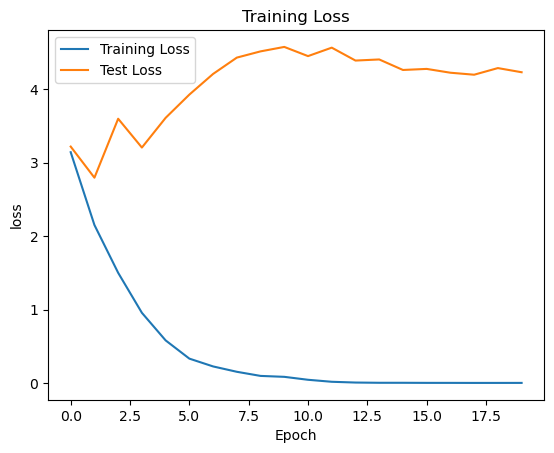

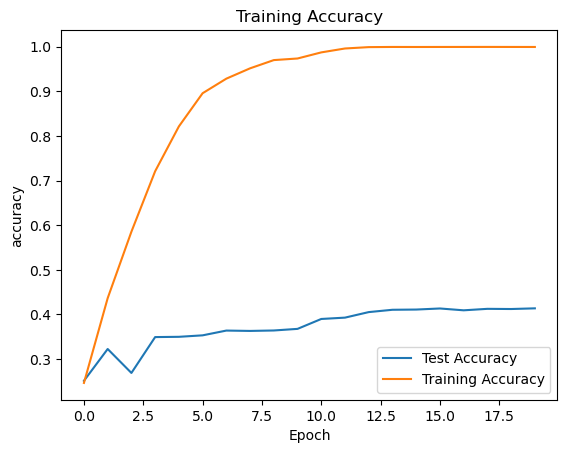

In [18]:
# Plotting training loss and accuracy
plt.plot(_log_train_loss, label='Training Loss')
plt.plot(_log_test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Training Loss')
plt.legend()
plt.show()


plt.plot(_log_test_acc, label='Test Accuracy')
plt.plot(_log_train_acc, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

In [19]:
torch.save(model.state_dict(), "models/Myresnet34.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [20]:
model = MyResNet34(Block, 100).to(device)
model.load_state_dict(torch.load("models/Myresnet34.pth"))

<All keys matched successfully>

In [21]:
model.named_modules

<bound method Module.named_modules of MyResNet34(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv64blocks): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU